In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import pingouin as pg
import copy

In [2]:
from scipy import stats
from scipy import sparse
import scipy.io as io

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
from functools import partial

In [4]:
from itertools import combinations

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [6]:
import mne
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,
                       permutation_t_test, permutation_cluster_1samp_test)

In [7]:
from mpl_toolkits.mplot3d import Axes3D

In [8]:
import matplotlib.pyplot as plt
font = {'family': 'sans-serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [9]:
pd.set_option('mode.chained_assignment', None)

In [10]:
label_fontsize = 16 
title_fontsize = 18

In [11]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

In [12]:
basefilelist = [#"11072018_SponSleep_LFP"   #-- 1(No calib), 
                 "27072018_SponSleep_LFP",  #-- 2
                 "14092018_SponSleep_LFP",  #-- 3
                 "17092018_SponSleep_LFP",  #-- 4
                #"19092018_SponSleep_LFP",  #-- 5(Noisy calib)
                 "30102018_SponSleep_LFP",  #-- 6
                 "01112018_SponSleep_LFP",  #-- 7
                 "03112018_SponSleep_LFP",  #-- 8
                 "13112018_SponSleep_LFP",  #-- 9 
                #"21112018_SponSleep_LFP",  #-- 10(Very little sleep trials)
                #"22112018_SponSleep_LFP",  #-- 11(Very Noisy calib)
                 "28112018_SponSleep_LFP",  #-- 12(Very little sleep trials)
                #"29112018_SponSleep_LFP",  #-- 13(Inactive after 4 hours)
                 "11122018_SponSleep_LFP",  #-- 14
                 "13122018_SponSleep_LFP",  #-- 15(Very awake fly)
                 "18122018_SponSleep_LFP",  #-- 16
                 "10012019_SponSleep_LFP",  #-- 17
                 "17012019_SponSleep_LFP",  #-- 18
                 "22012019_SponSleep_LFP",  #-- 19
                #"07022019_SponSleep_LFP",  #-- 20(No sleep data)
                 "20022019_SponSleep_LFP",  #-- 21
                #"06032019_SponSleep_LFP",  #-- 22(Noisy calib)
                 "13032019_SponSleep_LFP",  #-- 23
                ]

In [13]:
n_flies = len(basefilelist)
print("Total files considered: " + str(n_flies))

Total files considered: 16


In [14]:
reference = 'neutral' #'neutral','diff'

In [15]:
basefolder = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"

In [16]:
inputfolderpath = basefolder + "drosSleepStages_SciAdvances2023/data/lfp_data/spectrum/svmclassifier/"

In [17]:
classifiermetricspath = basefolder +\
                        "drosSleepStages_SciAdvances2023/data/lfp_data/spectrum/svmclassifier/classifiermetrics/"

In [18]:
states = ['awake', 'sleep']

In [19]:
outputfolderpath = basefolder + "SleepOnset_Drosophila/Scripts/pics/stats_grouplevel/"

In [20]:
def collatecsv():
    
    allfeatures_df = []
    
    for basefileidx in range(len(basefilelist)):
        basefilename = basefilelist[basefileidx]
        print('Processing: ', basefilename)
    
        inputfilepath = inputfolderpath + "Spectrum_CSV_" + reference + "_ref_" + basefilename + ".csv"
        features_spectrum_df = pd.read_csv(inputfilepath)
        
        if basefileidx == 0:
            allfeatures_df = features_spectrum_df 
        else:
            allfeatures_df = allfeatures_df.append(features_spectrum_df)
            
    return allfeatures_df

In [21]:
allfeatures_df = collatecsv()

Processing:  27072018_SponSleep_LFP
Processing:  14092018_SponSleep_LFP
Processing:  17092018_SponSleep_LFP
Processing:  30102018_SponSleep_LFP
Processing:  01112018_SponSleep_LFP
Processing:  03112018_SponSleep_LFP
Processing:  13112018_SponSleep_LFP
Processing:  28112018_SponSleep_LFP
Processing:  11122018_SponSleep_LFP
Processing:  13122018_SponSleep_LFP
Processing:  18122018_SponSleep_LFP
Processing:  10012019_SponSleep_LFP
Processing:  17012019_SponSleep_LFP
Processing:  22012019_SponSleep_LFP
Processing:  20022019_SponSleep_LFP
Processing:  13032019_SponSleep_LFP


In [22]:
allfeatures_df 

,freq4.88_chan01,freq4.88_chan02,freq4.88_chan03,freq4.88_chan04,freq4.88_chan05,freq4.88_chan06,freq4.88_chan07,freq4.88_chan08,freq4.88_chan09,freq4.88_chan10,...,freq40.04_chan09,freq40.04_chan10,freq40.04_chan11,freq40.04_chan12,freq40.04_chan13,freq40.04_chan14,freq40.04_chan15,state,depth,fly
0,16.907746,18.031327,16.695582,16.928798,15.740280,13.882950,12.989385,13.230149,12.057229,12.278152,...,6.573092,6.963042,3.228627,-0.163291,3.477128,5.864448,10.546624,awake,epoch01_depth33_min01,27072018_SponSleep_LFP
1,18.219623,17.288638,14.989972,14.163098,13.005335,11.676813,10.656620,9.535862,8.410238,8.727287,...,5.354519,4.539076,2.609511,-2.032236,0.119382,-0.759690,1.761731,awake,epoch01_depth33_min02,27072018_SponSleep_LFP
2,19.019229,18.067138,16.807576,16.786777,16.122223,15.413145,15.789958,13.978603,13.332066,12.588074,...,7.926903,8.933696,8.372123,3.774294,9.054524,11.292854,15.218561,awake,epoch01_depth33_min03,27072018_SponSleep_LFP
3,17.412197,15.146518,13.969461,13.137674,12.669202,12.023402,10.728541,10.636679,9.142379,8.341223,...,5.128774,4.678555,1.538661,-2.308884,-1.166614,0.845271,0.130059,awake,epoch01_depth33_min04,27072018_SponSleep_LFP
4,16.852660,15.657018,15.303795,15.510230,15.219867,14.411664,14.829397,14.049612,12.047110,12.566136,...,8.677771,9.350833,9.052597,2.516190,11.085336,13.465725,17.404638,awake,epoch01_depth33_min05,27072018_SponSleep_LFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,7.342010,6.563430,6.289323,5.399435,3.861182,2.509621,3.745524,4.254659,4.502609,1.546891,...,-1.044279,-2.114063,-3.353080,-5.153004,-3.265125,-5.357371,-3.567569,04min_outtrans,epoch02_depth01_min01,13032019_SponSleep_LFP
453,9.513795,8.425295,7.449079,6.978575,4.779282,3.044996,2.538782,3.482614,3.988221,2.222204,...,-2.633073,-3.929504,-4.281794,-2.163888,-3.127829,-3.069369,-2.522760,04min_outtrans,epoch03_depth01_min01,13032019_SponSleep_LFP
454,8.009331,7.503443,7.063239,6.034723,3.841179,4.243403,4.106011,3.667637,2.734163,0.889056,...,-2.312425,-3.476129,-3.992790,-4.065068,-4.100621,-3.435233,-4.213883,04min_outtrans,epoch04_depth01_min01,13032019_SponSleep_LFP
455,7.800338,7.912022,8.204519,6.998709,6.056658,5.119043,5.314915,4.031113,4.217865,0.980953,...,-1.462641,-1.615972,-4.345260,-4.109633,-4.971776,-4.240377,-3.788201,04min_outtrans,epoch05_depth01_min01,13032019_SponSleep_LFP


In [23]:
allfeatures_df['state'].value_counts()

awake             5106
sleep             1165
02min_outtrans     113
01min_outtrans     113
04min_outtrans     113
03min_outtrans     113
06min_intrans      112
05min_intrans      112
04min_intrans      112
03min_intrans      112
01min_intrans      112
02min_intrans      112
Name: state, dtype: int64

In [24]:
def balanced_spl_by(df, lblcol, random_state = 1 , uspl=True):
    datas_l = [ df[df[lblcol]==l].copy() for l in list(set(df[lblcol].values)) ]
    lsz = [f.shape[0] for f in datas_l ]
    
    tempval = pd.concat([f.sample(n = (min(lsz) if uspl else max(lsz)), replace = (not uspl), random_state = random_state).copy() for f in datas_l ], axis=0 )
    return tempval.sample(frac=1)

In [25]:
performance_list =[]

In [26]:
validlabels = states
validlabels

['awake', 'sleep']

In [27]:
classifierfeat_df = allfeatures_df.loc[allfeatures_df['state'].isin(validlabels)]
classifierfeat_df = classifierfeat_df.drop(['fly'], axis=1)
classifierfeat_df

,freq4.88_chan01,freq4.88_chan02,freq4.88_chan03,freq4.88_chan04,freq4.88_chan05,freq4.88_chan06,freq4.88_chan07,freq4.88_chan08,freq4.88_chan09,freq4.88_chan10,...,freq40.04_chan08,freq40.04_chan09,freq40.04_chan10,freq40.04_chan11,freq40.04_chan12,freq40.04_chan13,freq40.04_chan14,freq40.04_chan15,state,depth
0,16.907746,18.031327,16.695582,16.928798,15.740280,13.882950,12.989385,13.230149,12.057229,12.278152,...,7.075573,6.573092,6.963042,3.228627,-0.163291,3.477128,5.864448,10.546624,awake,epoch01_depth33_min01
1,18.219623,17.288638,14.989972,14.163098,13.005335,11.676813,10.656620,9.535862,8.410238,8.727287,...,6.245022,5.354519,4.539076,2.609511,-2.032236,0.119382,-0.759690,1.761731,awake,epoch01_depth33_min02
2,19.019229,18.067138,16.807576,16.786777,16.122223,15.413145,15.789958,13.978603,13.332066,12.588074,...,8.595126,7.926903,8.933696,8.372123,3.774294,9.054524,11.292854,15.218561,awake,epoch01_depth33_min03
3,17.412197,15.146518,13.969461,13.137674,12.669202,12.023402,10.728541,10.636679,9.142379,8.341223,...,5.286581,5.128774,4.678555,1.538661,-2.308884,-1.166614,0.845271,0.130059,awake,epoch01_depth33_min04
4,16.852660,15.657018,15.303795,15.510230,15.219867,14.411664,14.829397,14.049612,12.047110,12.566136,...,7.155333,8.677771,9.350833,9.052597,2.516190,11.085336,13.465725,17.404638,awake,epoch01_depth33_min05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,6.995741,7.139554,7.191808,5.892198,4.633192,4.215528,3.659376,3.313981,3.619003,1.908295,...,-0.810662,-3.100893,-3.580567,-4.262665,-4.950402,-3.662722,-3.699756,-3.204272,sleep,epoch07_depth12_min10
429,6.407594,6.547867,5.677527,5.327700,3.799384,2.778228,2.900355,2.299108,2.660859,1.158729,...,-2.868560,-4.196863,-5.801642,-5.678733,-4.571787,-4.193536,-4.517876,-4.049468,sleep,epoch07_depth12_min11
430,6.095323,4.935577,4.807396,4.129199,2.746842,3.138656,2.412982,1.038865,3.359684,0.838070,...,-0.818815,-1.575030,-3.768509,-3.037288,-3.419847,-4.055861,-3.772086,-3.154440,sleep,epoch07_depth12_min12
431,7.517302,5.329428,5.177765,5.111240,5.177282,4.590377,2.437040,2.316464,1.032249,-0.594389,...,-2.452894,-1.711556,-3.853601,-3.778735,-4.510248,-4.909622,-5.832337,-4.550130,sleep,epoch08_depth02_min01


In [28]:
randomstate_upsample = 1

In [29]:
#Convert each feature strings separately as mentioned below 
encoder = LabelEncoder() 
classifierfeat_df['state'] = encoder.fit_transform(classifierfeat_df['state'])

#for balancing the classes
classifierfeat_df = balanced_spl_by(classifierfeat_df, 'state', random_state=randomstate_upsample, uspl=False)

print(classifierfeat_df['state'].value_counts())

1    5106
0    5106
Name: state, dtype: int64


In [30]:
def computeclassifierprob(classifierfeat_df, randomstate_testtrainsplit):
    
    classifierdata  = classifierfeat_df.values

    # split into inputs and outputs
    x, y = classifierfeat_df.iloc[:, :-2], classifierfeat_df.iloc[:, -2]

    # split into train test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, 
                                                        random_state=randomstate_testtrainsplit)

    print(y_train.value_counts())
    print(y_test.value_counts())
    
    
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear', probability = True) # Linear Kernel

    #scale the data
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform (x_test)

    #Train the model using the training sets
    clf.fit(x_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(x_test)
    
    performance_list =[]
    
    
    # Model Accuracy: how often is the classifier correct?
    acc = metrics.accuracy_score(y_test, y_pred)

    roc_auc = metrics.roc_auc_score(y_test, y_pred)

    recall = metrics.recall_score(y_test, y_pred)

    precision = metrics.precision_score(y_test, y_pred)

    f1_score = metrics.f1_score(y_test, y_pred)

    performance_list.append([validlabels[0], validlabels[1], randomstate_testtrainsplit, acc, roc_auc, recall, 
                             precision, f1_score])

    performance_df = pd.DataFrame(performance_list, columns=['basecat', 'targetcat', 'iteration',
                                                             'accuracy', 'roc_auc', 'recall', 
                                                             'precision', 'f1_score'])
    
    # performance_df.to_csv(classifiermetricspath + 'states_classifiermetrics'+ ".csv", encoding='utf-8',
    #                       index=False)
    
    
    testlabels = allfeatures_df['state']
    testfeatures_df = allfeatures_df.drop(['fly','state','depth'], axis=1)
    
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(testfeatures_df.values)
    
    #Predict the response for the full dataset
    y_test_pred = clf.predict_proba(scaled_data)
    
    df1 = testlabels.copy()
    df1 = df1.reset_index(drop = True)
    
    np.unique(df1)
    
    df2 = pd.DataFrame(y_test_pred, columns = ['class0', 'class1'])
    
    dfs = [df1,df2]
    df = pd.concat(dfs,axis=1,ignore_index=True)
    df.columns = ['class', 'prob_class0', 'prob_class1']
    
    plot_df = df.groupby(['class'], as_index=False)['prob_class0'].mean()
    plot_df = plot_df.merge(df.groupby(['class'], as_index=False)['prob_class0'].sem(), on='class', how='outer')
    plot_df = plot_df.rename(columns = {'prob_class0_x': 'classifier_prob', 'prob_class0_y': 'sem'})

    return plot_df,performance_df

In [31]:
plot_df_01,performance_df_01 = computeclassifierprob(classifierfeat_df, randomstate_testtrainsplit = 1)

0    4085
1    4084
Name: state, dtype: int64
1    1022
0    1021
Name: state, dtype: int64


In [32]:
plot_df_02,performance_df_02 = computeclassifierprob(classifierfeat_df, randomstate_testtrainsplit = 2)

1    4085
0    4084
Name: state, dtype: int64
0    1022
1    1021
Name: state, dtype: int64


In [33]:
plot_df_03,performance_df_03 = computeclassifierprob(classifierfeat_df, randomstate_testtrainsplit = 3)

1    4085
0    4084
Name: state, dtype: int64
0    1022
1    1021
Name: state, dtype: int64


In [34]:
plot_df_04,performance_df_04 = computeclassifierprob(classifierfeat_df, randomstate_testtrainsplit = 4)

1    4085
0    4084
Name: state, dtype: int64
0    1022
1    1021
Name: state, dtype: int64


In [35]:
plot_df_05,performance_df_05 = computeclassifierprob(classifierfeat_df, randomstate_testtrainsplit = 5)

0    4085
1    4084
Name: state, dtype: int64
1    1022
0    1021
Name: state, dtype: int64


In [36]:
mergedperf_df = pd.concat([performance_df_01, performance_df_02, performance_df_03, 
                           performance_df_04, performance_df_05])
mergedperf_df

,basecat,targetcat,iteration,accuracy,roc_auc,recall,precision,f1_score
0,awake,sleep,1,0.969163,0.969153,0.990215,0.950235,0.969813
0,awake,sleep,2,0.952521,0.952539,0.989226,0.921533,0.954180
0,awake,sleep,3,0.954968,0.954983,0.985309,0.928901,0.956274
0,awake,sleep,4,0.963779,0.963790,0.986288,0.943768,0.964559
0,awake,sleep,5,0.957905,0.957888,0.992172,0.928571,0.959319


In [37]:
mergedplot_df = pd.concat([plot_df_01, plot_df_02, plot_df_03, 
                           plot_df_04, plot_df_05])
mergedplot_df = mergedplot_df.reset_index(drop=True)
mergedplot_df

,class,classifier_prob,sem
0,01min_intrans,0.485150,0.037723
1,01min_outtrans,0.225554,0.030400
2,02min_intrans,0.486552,0.038563
3,02min_outtrans,0.250425,0.032882
4,03min_intrans,0.452690,0.038348
5,03min_outtrans,0.620287,0.037486
6,04min_intrans,0.584754,0.039731
7,04min_outtrans,0.553565,0.037743
8,05min_intrans,0.306129,0.032446
9,06min_intrans,0.260507,0.031392


In [38]:
time_dict ={'awake': -7,
            '01min_intrans':-3.5,'02min_intrans':-2.5,'03min_intrans':-1.5,
            '04min_intrans':-0.5,'05min_intrans':0.5,'06min_intrans':1.5,
            'sleep': 5,
            '01min_outtrans':8.5,'02min_outtrans':9.5,'03min_outtrans':10.5,
            '04min_outtrans':11.5}

In [39]:
timelabel_dict ={'awake': 'awake',
                 '01min_intrans':'-4:-3','02min_intrans':'-3:-2','03min_intrans':'-2:-1',
                 '04min_intrans':'-1:+0','05min_intrans':'+0:+1','06min_intrans':'+1:+2',
                 'sleep': 'sleep',
                 '01min_outtrans':'x:-2','02min_outtrans':'x:-1','03min_outtrans':'x:+1',
                 '04min_outtrans':'x:+2'}

In [40]:
mergedplot_df['time'] = mergedplot_df['class'].map(time_dict)
mergedplot_df['time_label'] = mergedplot_df['class'].map(timelabel_dict)
mergedplot_df = mergedplot_df.sort_values(by=['time'])
mergedplot_df

,class,classifier_prob,sem,time,time_label
46,awake,0.699212,0.005067,-7.0,awake
58,awake,0.702822,0.005120,-7.0,awake
22,awake,0.698559,0.005055,-7.0,awake
34,awake,0.706545,0.004988,-7.0,awake
10,awake,0.693777,0.004938,-7.0,awake
24,01min_intrans,0.502522,0.039080,-3.5,-4:-3
48,01min_intrans,0.486936,0.039048,-3.5,-4:-3
12,01min_intrans,0.482927,0.038753,-3.5,-4:-3
0,01min_intrans,0.485150,0.037723,-3.5,-4:-3
36,01min_intrans,0.526821,0.039862,-3.5,-4:-3


In [41]:
res1 = pg.ttest(mergedplot_df['classifier_prob'][mergedplot_df['class'] == '01min_intrans'].values,
               mergedplot_df['classifier_prob'][mergedplot_df['class'] == '02min_intrans'].values,
               correction = False)
res1

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.406679,8,two-sided,0.694907,"[-0.02, 0.03]",0.257206,0.519,0.065


In [42]:
res2 = pg.ttest(mergedplot_df['classifier_prob'][mergedplot_df['class'] == '02min_intrans'].values,
               mergedplot_df['classifier_prob'][mergedplot_df['class'] == '03min_intrans'].values,
               correction = False)
res2

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.154093,8,two-sided,0.003191,"[0.01, 0.05]",2.627279,11.581,0.951522


In [43]:
res3 = pg.ttest(mergedplot_df['classifier_prob'][mergedplot_df['class'] == '03min_intrans'].values,
               mergedplot_df['classifier_prob'][mergedplot_df['class'] == '04min_intrans'].values,
               correction = False)
res3

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-19.735185,8,two-sided,4.523706e-08,"[-0.14, -0.11]",12.481627,1.132e+05,1.0


In [44]:
res4 = pg.ttest(mergedplot_df['classifier_prob'][mergedplot_df['class'] == '04min_intrans'].values,
               mergedplot_df['classifier_prob'][mergedplot_df['class'] == '05min_intrans'].values,
               correction = False)
res4

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,44.790754,8,two-sided,6.815360e-11,"[0.28, 0.31]",28.32816,3.244e+07,1.0


In [45]:
res5 = pg.ttest(mergedplot_df['classifier_prob'][mergedplot_df['class'] == '05min_intrans'].values,
               mergedplot_df['classifier_prob'][mergedplot_df['class'] == '06min_intrans'].values,
               correction = False)
res5

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.443733,8,two-sided,0.002157,"[0.02, 0.06]",2.810464,15.392,0.971744


In [46]:
res6 = pg.ttest(mergedplot_df['classifier_prob'][mergedplot_df['class'] == '01min_outtrans'].values,
               mergedplot_df['classifier_prob'][mergedplot_df['class'] == '02min_outtrans'].values,
               correction = False)
res6

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.449429,8,two-sided,0.039972,"[-0.03, -0.0]",1.549155,2.132,0.575968


In [47]:
res7 = pg.ttest(mergedplot_df['classifier_prob'][mergedplot_df['class'] == '02min_outtrans'].values,
               mergedplot_df['classifier_prob'][mergedplot_df['class'] == '03min_outtrans'].values,
               correction = False)
res7

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-60.220737,8,two-sided,6.423981e-12,"[-0.38, -0.35]",38.086938,2.554e+08,1.0


In [48]:
res8 = pg.ttest(mergedplot_df['classifier_prob'][mergedplot_df['class'] == '03min_outtrans'].values,
               mergedplot_df['classifier_prob'][mergedplot_df['class'] == '04min_outtrans'].values,
               correction = False)
res8

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,11.545752,8,two-sided,0.000003,"[0.05, 0.08]",7.302175,3195.807,1.0


In [49]:
kwargs  =   {'edgecolor':"black", # for edge color
             'linewidth':1, # line width of spot
             'linestyle':'-', # line style of spot
            }

In [50]:
color_dict = dict({'awake':'#B34D4D',
                   '01min_intrans':'#B34D4D','02min_intrans':'#B34D4D',
                   '03min_intrans':'#F2AF0D','04min_intrans':'#F2AF0D',
                   '05min_intrans':'#1AC2E6','06min_intrans':'#1AC2E6',
                   'sleep':'#0D28F2',
                   '01min_outtrans':'#B3704D','02min_outtrans':'#B3704D',
                   '03min_outtrans':'#B34D4D','04min_outtrans':'#B34D4D',
                  })

In [51]:
def statannotation(ax, x1, x2, y,text):
    h = 0.025
    text_offset = 1
    
    line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]

    ax.plot(line_x, line_y, lw=2, c='black')
    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                      xytext=(0, text_offset), textcoords='offset points',
                      xycoords='data', ha='center', va='bottom',
                      fontsize=label_fontsize-2, clip_on=False, annotation_clip=False)

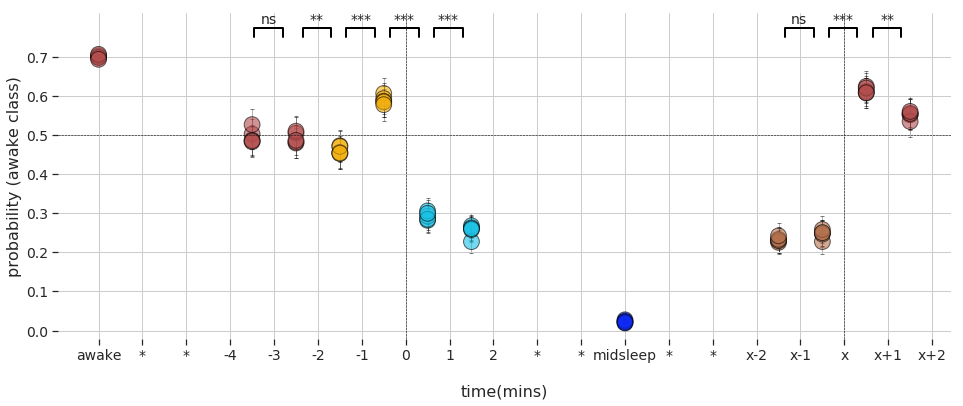

In [52]:
f, (ax1) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(16, 6))

ax1 = sns.scatterplot(data=mergedplot_df, x="time", y="classifier_prob", ax = ax1, hue = 'class',
                      **kwargs, s= 250, palette=color_dict, alpha = 0.6)
                      #linestyles=' ',edgecolors = 'black', marker='o')


# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax1.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

errors = mergedplot_df['sem']
(_, caps, _) = ax1.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', capsize=2,
                            zorder=-1, color = 'black', alpha = 0.5)


for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax1.legend_.remove()

ax1.set_xticks(np.arange(-8,14))
ax1.set_yticks(np.arange(0,0.8,0.1))

string_val1 = 'ns'
statannotation(ax = ax1, x1 = -3.45, x2 = -3.45+0.65, y = 0.75, text = string_val1)

string_val2 = '**'
statannotation(ax = ax1, x1 = -2.35, x2 = -2.35+0.65, y = 0.75, text = string_val2)

string_val3 = '***'
statannotation(ax = ax1, x1 = -1.35, x2 = -1.35+0.65, y = 0.75, text = string_val3)

string_val4 = '***'
statannotation(ax = ax1, x1 = -0.35, x2 = -0.35+0.65, y = 0.75, text = string_val4)

string_val5 = '***'
statannotation(ax = ax1, x1 = 0.65, x2 = 0.65+0.65, y = 0.75, text = string_val5)

string_val6 = 'ns'
statannotation(ax = ax1, x1 = 8.65, x2 = 8.65+0.65, y = 0.75, text = string_val6)

string_val7 = '***'
statannotation(ax = ax1, x1 = 9.65, x2 = 9.65+0.65, y = 0.75, text = string_val7)

string_val8 = '**'
statannotation(ax = ax1, x1 = 10.65, x2 = 10.65+0.65, y = 0.75, text = string_val8)


# ax1.set_xticks(plot_df['time'])
labels = ['','awake','*','*',
          '-4','-3','-2','-1',
           '0','1','2',
          '*','*','midsleep','*','*',
          'x-2','x-1','x',
          'x+1','x+2',''
          ]

ax1.set_xticklabels(labels)

ax1.axhline(0.5, ls='--', color = 'k')

ax1.axvline(0, ls='--', color = 'k')
ax1.axvline(10, ls='--', color = 'k')

ax1.set_ylabel('probability (awake class)', fontsize=label_fontsize)
ax1.set_xlabel('\ntime(mins)', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)
plt.box(False)

# plt.savefig(outputfolderpath +  'classifier_probability_awake_sleep.png', format='png', dpi=300, 
#             transparent=False,bbox_inches='tight')

In [53]:
plotmergedperf_df = mergedperf_df.drop(['basecat', 'targetcat','iteration'], axis=1)
plotmergedperf_df

,accuracy,roc_auc,recall,precision,f1_score
0,0.969163,0.969153,0.990215,0.950235,0.969813
0,0.952521,0.952539,0.989226,0.921533,0.954180
0,0.954968,0.954983,0.985309,0.928901,0.956274
0,0.963779,0.963790,0.986288,0.943768,0.964559
0,0.957905,0.957888,0.992172,0.928571,0.959319


In [54]:
vals, names, xs = [],[],[]
for i, col in enumerate(plotmergedperf_df.columns):
    vals.append(plotmergedperf_df[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, plotmergedperf_df[col].values.shape[0]))  
    #adds jitter to the data points - can be adjusted

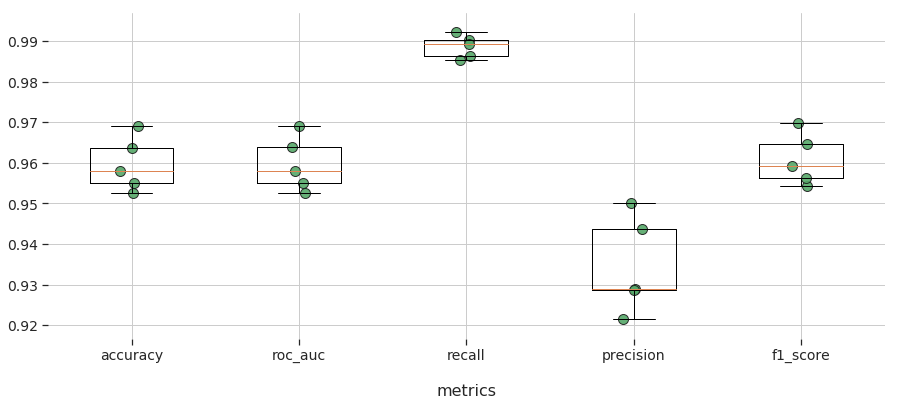

In [55]:
f, (ax1) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(15, 6))

plt.boxplot(vals, labels=names)  # notch=True adds median notch
ngroup = len(vals)

for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.9, edgecolors = 'k', color='g', s = 100)
    
plt.xlabel("\nmetrics", fontsize=label_fontsize)
plt.ylabel("", fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

ax1.grid(True)
plt.box(False)

# plt.savefig(outputfolderpath +  'classifier_probability_awake_sleep_metrics.png', format='png', dpi=300, 
#             transparent=False,bbox_inches='tight')

In [56]:
depth_numbers = allfeatures_df['depth'].str.extract(r'depth(\d+)')[0]
allfeatures_df['sleepdepth'] = depth_numbers.astype('int')

In [57]:
epoch_depth = allfeatures_df['depth'].str.extract(r'min(\d+)')[0]
allfeatures_df['epochdepth'] = epoch_depth.astype('int')

In [58]:
allfeatures_df['sleepdepth'][allfeatures_df['state'] == 'awake'] = np.nan

allfeatures_df['sleepdepth'][allfeatures_df['state'] == '01min_intrans'] = np.nan
allfeatures_df['sleepdepth'][allfeatures_df['state'] == '02min_intrans'] = np.nan
allfeatures_df['sleepdepth'][allfeatures_df['state'] == '03min_intrans'] = np.nan
allfeatures_df['sleepdepth'][allfeatures_df['state'] == '04min_intrans'] = np.nan
allfeatures_df['sleepdepth'][allfeatures_df['state'] == '05min_intrans'] = np.nan
allfeatures_df['sleepdepth'][allfeatures_df['state'] == '06min_intrans'] = np.nan

allfeatures_df['sleepdepth'][allfeatures_df['state'] == '01min_outtrans'] = np.nan
allfeatures_df['sleepdepth'][allfeatures_df['state'] == '02min_outtrans'] = np.nan
allfeatures_df['sleepdepth'][allfeatures_df['state'] == '03min_outtrans'] = np.nan
allfeatures_df['sleepdepth'][allfeatures_df['state'] == '04min_outtrans'] = np.nan

In [59]:
allfeatures_df['state'].unique()

array(['awake', '01min_intrans', '02min_intrans', '03min_intrans',
       '04min_intrans', '05min_intrans', '06min_intrans', 'sleep',
       '01min_outtrans', '02min_outtrans', '03min_outtrans',
       '04min_outtrans'], dtype=object)

In [60]:
allfeatures_df.head()

,freq4.88_chan01,freq4.88_chan02,freq4.88_chan03,freq4.88_chan04,freq4.88_chan05,freq4.88_chan06,freq4.88_chan07,freq4.88_chan08,freq4.88_chan09,freq4.88_chan10,...,freq40.04_chan11,freq40.04_chan12,freq40.04_chan13,freq40.04_chan14,freq40.04_chan15,state,depth,fly,sleepdepth,epochdepth
0,16.907746,18.031327,16.695582,16.928798,15.740280,13.882950,12.989385,13.230149,12.057229,12.278152,...,3.228627,-0.163291,3.477128,5.864448,10.546624,awake,epoch01_depth33_min01,27072018_SponSleep_LFP,NaN,1
1,18.219623,17.288638,14.989972,14.163098,13.005335,11.676813,10.656620,9.535862,8.410238,8.727287,...,2.609511,-2.032236,0.119382,-0.759690,1.761731,awake,epoch01_depth33_min02,27072018_SponSleep_LFP,NaN,2
2,19.019229,18.067138,16.807576,16.786777,16.122223,15.413145,15.789958,13.978603,13.332066,12.588074,...,8.372123,3.774294,9.054524,11.292854,15.218561,awake,epoch01_depth33_min03,27072018_SponSleep_LFP,NaN,3
3,17.412197,15.146518,13.969461,13.137674,12.669202,12.023402,10.728541,10.636679,9.142379,8.341223,...,1.538661,-2.308884,-1.166614,0.845271,0.130059,awake,epoch01_depth33_min04,27072018_SponSleep_LFP,NaN,4
4,16.852660,15.657018,15.303795,15.510230,15.219867,14.411664,14.829397,14.049612,12.047110,12.566136,...,9.052597,2.516190,11.085336,13.465725,17.404638,awake,epoch01_depth33_min05,27072018_SponSleep_LFP,NaN,5


In [61]:
np.unique(allfeatures_df['sleepdepth'])

array([ 1.,  2.,  3., ..., nan, nan, nan])

In [62]:
allfeatures_df.groupby(["fly","sleepdepth"]).size()

fly                     sleepdepth
01112018_SponSleep_LFP  2.0            2
                        3.0            3
                        4.0            4
                        5.0           10
                        11.0          11
                                      ..
30102018_SponSleep_LFP  7.0            7
                        9.0            9
                        11.0          11
                        13.0          13
                        14.0          14
Length: 99, dtype: int64

In [63]:
sleepdepthcnt_df = allfeatures_df['sleepdepth'].value_counts().rename_axis('sleepdepth').reset_index(name='counts')
sleepdepthcnt_df.sort_values(by=['sleepdepth'], ascending = False)

,sleepdepth,counts
10,46.0,46
13,38.0,38
0,36.0,108
17,29.0,29
18,27.0,27
20,26.0,26
3,23.0,69
22,21.0,21
24,20.0,20
25,19.0,19


In [64]:
allfeatures_df[allfeatures_df['sleepdepth'] == 36]['fly'].value_counts()

17092018_SponSleep_LFP    72
03112018_SponSleep_LFP    36
Name: fly, dtype: int64

In [65]:
allfeatures_df[allfeatures_df['sleepdepth'] == 38]['fly'].value_counts()

13112018_SponSleep_LFP    38
Name: fly, dtype: int64

In [66]:
allfeatures_df[allfeatures_df['sleepdepth'] == 46]['fly'].value_counts()

03112018_SponSleep_LFP    46
Name: fly, dtype: int64

In [67]:
allfeatures_df['state'].unique()

array(['awake', '01min_intrans', '02min_intrans', '03min_intrans',
       '04min_intrans', '05min_intrans', '06min_intrans', 'sleep',
       '01min_outtrans', '02min_outtrans', '03min_outtrans',
       '04min_outtrans'], dtype=object)

In [68]:
sleepfeatures_df = allfeatures_df[allfeatures_df['state'] == 'sleep']

In [69]:
epoch_num = sleepfeatures_df['depth'].str.extract(r'epoch(\d+)')[0]
sleep_depth = sleepfeatures_df['depth'].str.extract(r'depth(\d+)')[0]
sleepfeatures_df['epoch_fly_depths'] = 'epoch_' + epoch_num + '_' + sleepfeatures_df['fly'] + '_' +\
                                        'depth' + '_' + sleep_depth

In [70]:
sleepfeatures_df.head()

,freq4.88_chan01,freq4.88_chan02,freq4.88_chan03,freq4.88_chan04,freq4.88_chan05,freq4.88_chan06,freq4.88_chan07,freq4.88_chan08,freq4.88_chan09,freq4.88_chan10,...,freq40.04_chan12,freq40.04_chan13,freq40.04_chan14,freq40.04_chan15,state,depth,fly,sleepdepth,epochdepth,epoch_fly_depths
268,15.397181,14.536723,11.269412,9.736971,10.188880,8.649561,6.316897,9.334616,8.477718,9.417471,...,-2.721051,-0.861092,0.932858,0.804778,sleep,epoch01_depth21_min01,27072018_SponSleep_LFP,21.0,1,epoch_01_27072018_SponSleep_LFP_depth_21
269,16.021100,16.047866,13.074603,11.807038,11.802174,9.891708,6.907031,7.907295,6.232210,7.534681,...,-1.996320,-0.794122,-0.420608,0.451038,sleep,epoch01_depth21_min02,27072018_SponSleep_LFP,21.0,2,epoch_01_27072018_SponSleep_LFP_depth_21
270,16.626143,15.816770,16.704307,12.389862,11.746961,10.572614,9.270850,9.483054,8.290998,7.969964,...,-1.684658,-1.055798,-1.142812,0.220128,sleep,epoch01_depth21_min03,27072018_SponSleep_LFP,21.0,3,epoch_01_27072018_SponSleep_LFP_depth_21
271,15.526393,15.049391,12.436114,11.116274,12.015591,10.733514,8.724857,8.174308,7.858099,7.182198,...,-1.643332,-2.251290,-0.055544,-0.408968,sleep,epoch01_depth21_min04,27072018_SponSleep_LFP,21.0,4,epoch_01_27072018_SponSleep_LFP_depth_21
272,16.713762,16.379728,13.205477,11.599515,11.220488,9.093497,7.826592,8.922464,7.527388,8.185635,...,-1.338995,-1.302049,-0.045147,0.519416,sleep,epoch01_depth21_min05,27072018_SponSleep_LFP,21.0,5,epoch_01_27072018_SponSleep_LFP_depth_21


In [71]:
uniquesleepdepths = np.unique(sleepfeatures_df['epoch_fly_depths'])

In [72]:
len(uniquesleepdepths)

131

In [73]:
uniquesleepdepths

array(['epoch_01_01112018_SponSleep_LFP_depth_16',
       'epoch_01_03112018_SponSleep_LFP_depth_46',
       'epoch_01_10012019_SponSleep_LFP_depth_05',
       'epoch_01_11122018_SponSleep_LFP_depth_01',
       'epoch_01_13032019_SponSleep_LFP_depth_11',
       'epoch_01_13112018_SponSleep_LFP_depth_13',
       'epoch_01_13122018_SponSleep_LFP_depth_18',
       'epoch_01_14092018_SponSleep_LFP_depth_04',
       'epoch_01_17012019_SponSleep_LFP_depth_03',
       'epoch_01_17092018_SponSleep_LFP_depth_03',
       'epoch_01_18122018_SponSleep_LFP_depth_01',
       'epoch_01_20022019_SponSleep_LFP_depth_01',
       'epoch_01_22012019_SponSleep_LFP_depth_15',
       'epoch_01_27072018_SponSleep_LFP_depth_21',
       'epoch_01_28112018_SponSleep_LFP_depth_03',
       'epoch_01_30102018_SponSleep_LFP_depth_04',
       'epoch_02_01112018_SponSleep_LFP_depth_03',
       'epoch_02_03112018_SponSleep_LFP_depth_36',
       'epoch_02_10012019_SponSleep_LFP_depth_08',
       'epoch_02_11122018_SponS

In [74]:
collated_sleepdepth = [int(element[element.find('depth_') + 6:]) for element in uniquesleepdepths]

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


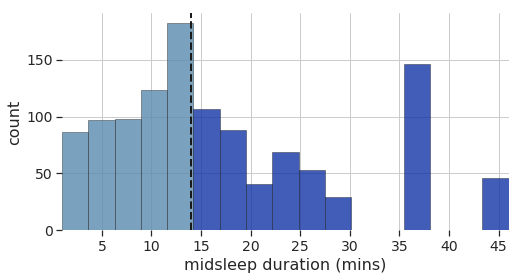

In [75]:
fig = plt.figure(figsize=(8, 4))
gs_main = gridspec.GridSpec(1, 1,width_ratios=[4])
gs_main.update(wspace=0.25, hspace=0.2)


gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])

ax1 = sns.histplot(data=sleepfeatures_df,
                   x="sleepdepth", stat = 'count', kde = False, ax = ax1,  
                   color="b",edgecolor="k", alpha = 0.5, linewidth=0.5)

for i in range(0,5):
    ax1.patches[i].set_facecolor('#598BAF')
    ax1.patches[i].set_alpha(0.8)
for i in range(5,17):    
    ax1.patches[i].set_facecolor('#1134A6')
    ax1.patches[i].set_alpha(0.8)

ax1.grid(True)

ax1.set_ylabel('count', fontsize=label_fontsize)
ax1.set_xlabel('midsleep duration (mins)', fontsize=label_fontsize)
ax1.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.margins(x=0)

ax1.axvline(np.nanpercentile(sleepfeatures_df['sleepdepth'], 50), ls='--', color = 'k',linewidth = 2)

sns.despine(left=True, bottom=True, right=True)

plt.tight_layout()
plt.box(False)

# plt.savefig(outputfolderpath +  'classifier_midsleepdepth.png', format='png', dpi=300, 
#             transparent=False,bbox_inches='tight')

In [76]:
#just another way of displaying the bout counts alone, instead of the class counts 
#used by the classifier like above

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


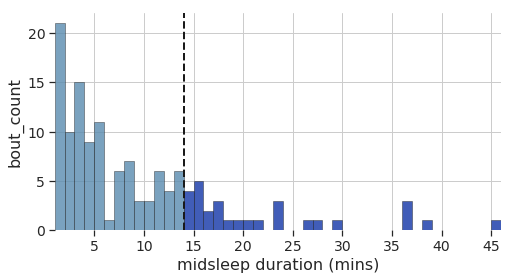

In [96]:
fig = plt.figure(figsize=(8, 4))
gs_main = gridspec.GridSpec(1, 1,width_ratios=[4])
gs_main.update(wspace=0.25, hspace=0.2)


gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])

ax1 = sns.histplot(x=collated_sleepdepth, stat = 'count', kde = False, ax = ax1, binwidth=1,
                   color="b",edgecolor="k", alpha = 0.5, linewidth=0.5)


for i in range(0,13):
    ax1.patches[i].set_facecolor('#598BAF')
    ax1.patches[i].set_alpha(0.8)
for i in range(13,45):    
    ax1.patches[i].set_facecolor('#1134A6')
    ax1.patches[i].set_alpha(0.8)

ax1.grid(True)


ax1.set_ylabel('bout_count', fontsize=label_fontsize)
ax1.set_xlabel('midsleep duration (mins)', fontsize=label_fontsize)
ax1.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.margins(x=0)

ax1.axvline(np.nanpercentile(sleepfeatures_df['sleepdepth'], 50), ls='--', color = 'k',linewidth = 2)

sns.despine(left=True, bottom=True, right=True)

plt.tight_layout()
plt.box(False)


In [97]:
print(allfeatures_df['state'].value_counts())

awake             5106
sleep             1165
02min_outtrans     113
01min_outtrans     113
04min_outtrans     113
03min_outtrans     113
06min_intrans      112
05min_intrans      112
04min_intrans      112
03min_intrans      112
01min_intrans      112
02min_intrans      112
Name: state, dtype: int64


In [98]:
np.nanpercentile(allfeatures_df['sleepdepth'], 50)

14.0

In [99]:
cutoffsleepmins = 14

In [100]:
subclassvalidlabels = ['sleep']

In [101]:
lightdeepsleepclasfeat_df = allfeatures_df.loc[allfeatures_df['state'].isin(subclassvalidlabels)]
lightdeepsleepclasfeat_df = lightdeepsleepclasfeat_df.drop(['fly'], axis=1)
lightdeepsleepclasfeat_df['state'][lightdeepsleepclasfeat_df['sleepdepth'] <cutoffsleepmins] = 'shortmidsleep'
lightdeepsleepclasfeat_df['state'][lightdeepsleepclasfeat_df['sleepdepth'] >=cutoffsleepmins] = 'longmidsleep'
lightdeepsleepclasfeat_df

,freq4.88_chan01,freq4.88_chan02,freq4.88_chan03,freq4.88_chan04,freq4.88_chan05,freq4.88_chan06,freq4.88_chan07,freq4.88_chan08,freq4.88_chan09,freq4.88_chan10,...,freq40.04_chan10,freq40.04_chan11,freq40.04_chan12,freq40.04_chan13,freq40.04_chan14,freq40.04_chan15,state,depth,sleepdepth,epochdepth
268,15.397181,14.536723,11.269412,9.736971,10.188880,8.649561,6.316897,9.334616,8.477718,9.417471,...,3.978323,1.710795,-2.721051,-0.861092,0.932858,0.804778,longmidsleep,epoch01_depth21_min01,21.0,1
269,16.021100,16.047866,13.074603,11.807038,11.802174,9.891708,6.907031,7.907295,6.232210,7.534681,...,4.936714,2.106289,-1.996320,-0.794122,-0.420608,0.451038,longmidsleep,epoch01_depth21_min02,21.0,2
270,16.626143,15.816770,16.704307,12.389862,11.746961,10.572614,9.270850,9.483054,8.290998,7.969964,...,4.089048,1.824616,-1.684658,-1.055798,-1.142812,0.220128,longmidsleep,epoch01_depth21_min03,21.0,3
271,15.526393,15.049391,12.436114,11.116274,12.015591,10.733514,8.724857,8.174308,7.858099,7.182198,...,4.388443,1.884156,-1.643332,-2.251290,-0.055544,-0.408968,longmidsleep,epoch01_depth21_min04,21.0,4
272,16.713762,16.379728,13.205477,11.599515,11.220488,9.093497,7.826592,8.922464,7.527388,8.185635,...,5.289952,1.156875,-1.338995,-1.302049,-0.045147,0.519416,longmidsleep,epoch01_depth21_min05,21.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,6.995741,7.139554,7.191808,5.892198,4.633192,4.215528,3.659376,3.313981,3.619003,1.908295,...,-3.580567,-4.262665,-4.950402,-3.662722,-3.699756,-3.204272,shortmidsleep,epoch07_depth12_min10,12.0,10
429,6.407594,6.547867,5.677527,5.327700,3.799384,2.778228,2.900355,2.299108,2.660859,1.158729,...,-5.801642,-5.678733,-4.571787,-4.193536,-4.517876,-4.049468,shortmidsleep,epoch07_depth12_min11,12.0,11
430,6.095323,4.935577,4.807396,4.129199,2.746842,3.138656,2.412982,1.038865,3.359684,0.838070,...,-3.768509,-3.037288,-3.419847,-4.055861,-3.772086,-3.154440,shortmidsleep,epoch07_depth12_min12,12.0,12
431,7.517302,5.329428,5.177765,5.111240,5.177282,4.590377,2.437040,2.316464,1.032249,-0.594389,...,-3.853601,-3.778735,-4.510248,-4.909622,-5.832337,-4.550130,shortmidsleep,epoch08_depth02_min01,2.0,1


In [102]:
lightdeepsleepclasfeat_df['state'].unique()

array(['longmidsleep', 'shortmidsleep'], dtype=object)

In [103]:
print(lightdeepsleepclasfeat_df['state'].value_counts())

longmidsleep     635
shortmidsleep    530
Name: state, dtype: int64


In [104]:
print('min duration :', np.min(lightdeepsleepclasfeat_df['sleepdepth']))
print('max duration :', np.max(lightdeepsleepclasfeat_df['sleepdepth']))

min duration : 1.0
max duration : 46.0


In [105]:
lightdeepsleepclasfeat_df.groupby('state').sleepdepth.agg(['min', 'max'])

,min,max
state,,
longmidsleep,14.0,46.0
shortmidsleep,1.0,13.0


In [106]:
randomstate_upsample = 1

In [107]:
#Convert each feature strings separately as mentioned below 
encoder = LabelEncoder() 
lightdeepsleepclasfeat_df['state'] = encoder.fit_transform(lightdeepsleepclasfeat_df['state'])

#for balancing the classes
lightdeepsleepclasfeat_df = balanced_spl_by(lightdeepsleepclasfeat_df, 'state', random_state=randomstate_upsample,
                                          uspl=False)

print(lightdeepsleepclasfeat_df['state'].value_counts())

1    635
0    635
Name: state, dtype: int64


In [108]:
lightdeepsleepclasfeat_df = lightdeepsleepclasfeat_df.replace({'state': {0: 1, 1: 0}})

In [109]:
validlabels2 = ['shortmidsleep', 'longmidsleep']

In [110]:
def computeclassifierprob3(classifierfeat_df3, randomstate_testtrainsplit):
    
    classifierdata3  = classifierfeat_df3.values

    # split into inputs and outputs
    x, y = classifierfeat_df3.iloc[:, :-4], classifierfeat_df3.iloc[:, -4]

    # split into train test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, 
                                                        random_state=randomstate_testtrainsplit)

    print(y_train.value_counts())
    print(y_test.value_counts())
    
    
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear', probability = True) # Linear Kernel

    #scale the data
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform (x_test)

    #Train the model using the training sets
    clf.fit(x_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(x_test)
    
    performance_list =[]
    
    
    # Model Accuracy: how often is the classifier correct?
    acc = metrics.accuracy_score(y_test, y_pred)

    roc_auc = metrics.roc_auc_score(y_test, y_pred)

    recall = metrics.recall_score(y_test, y_pred)

    precision = metrics.precision_score(y_test, y_pred)

    f1_score = metrics.f1_score(y_test, y_pred)

    performance_list.append([validlabels2[0], validlabels2[1], randomstate_testtrainsplit, acc, roc_auc, recall, 
                             precision, f1_score])

    performance_df = pd.DataFrame(performance_list, columns=['basecat', 'targetcat', 'iteration',
                                                             'accuracy', 'roc_auc', 'recall', 
                                                             'precision', 'f1_score'])
    
    # performance_df.to_csv(classifiermetricspath + 'states_classifiermetrics'+ ".csv", encoding='utf-8',
    #                       index=False)
    
    
    testlabels = allfeatures_df['state']
    testdepths = allfeatures_df['sleepdepth']
    testfeatures_df = allfeatures_df.drop(['fly','state','depth','sleepdepth','epochdepth'], axis=1)

    
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(testfeatures_df.values)
    
    #Predict the response for the full dataset
    y_test_pred = clf.predict_proba(scaled_data)
    
    df1 = testlabels.copy()
    df1 = df1.reset_index(drop = True)
    
    np.unique(df1)
    
    df2 = pd.DataFrame(y_test_pred, columns = ['class0', 'class1'])
    
    df3 = testdepths.copy()
    df3 = df3.reset_index(drop = True)
    
    dfs = [df1,df3,df2]
    df = pd.concat(dfs,axis=1,ignore_index=True)
    df.columns = ['class', 'depth', 'prob_class0', 'prob_class1']
    
    df['depthcat'] = 'NA'
    
    df['depthcat'][df['class'] == 'awake'] = 'awake'
    df['depthcat'][df['depth'] <cutoffsleepmins] = 'shortmidsleep'
    df['depthcat'][df['depth'] >=cutoffsleepmins] = 'longmidsleep'
    
    
    df['depthcat'].unique()
       
    plot_df = df.groupby(['depthcat'], as_index=False)['prob_class0'].mean()
    plot_df = plot_df.merge(df.groupby(['depthcat'], as_index=False)['prob_class0'].sem(), on='depthcat',
                            how='outer')
    plot_df = plot_df.rename(columns = {'prob_class0_x': 'classifier_prob', 'prob_class0_y': 'sem'})


    return plot_df,performance_df

In [111]:
lightdeepsleepplot_df_01,lightdeepsleepperformance_df_01 = computeclassifierprob3(lightdeepsleepclasfeat_df,
                                                                              randomstate_testtrainsplit = 1)

1    508
0    508
Name: state, dtype: int64
1    127
0    127
Name: state, dtype: int64


In [112]:
lightdeepsleepplot_df_02,lightdeepsleepperformance_df_02 = computeclassifierprob3(lightdeepsleepclasfeat_df,
                                                                              randomstate_testtrainsplit = 2)

1    508
0    508
Name: state, dtype: int64
1    127
0    127
Name: state, dtype: int64


In [113]:
lightdeepsleepplot_df_03,lightdeepsleepperformance_df_03 = computeclassifierprob3(lightdeepsleepclasfeat_df,
                                                                              randomstate_testtrainsplit = 3)

1    508
0    508
Name: state, dtype: int64
1    127
0    127
Name: state, dtype: int64


In [114]:
lightdeepsleepplot_df_04,lightdeepsleepperformance_df_04 = computeclassifierprob3(lightdeepsleepclasfeat_df,
                                                                              randomstate_testtrainsplit = 4)

1    508
0    508
Name: state, dtype: int64
1    127
0    127
Name: state, dtype: int64


In [115]:
lightdeepsleepplot_df_05,lightdeepsleepperformance_df_05 = computeclassifierprob3(lightdeepsleepclasfeat_df,
                                                                              randomstate_testtrainsplit = 5)

1    508
0    508
Name: state, dtype: int64
1    127
0    127
Name: state, dtype: int64


In [116]:
mergedlightdeepsleepperf_df = pd.concat([lightdeepsleepperformance_df_01, lightdeepsleepperformance_df_02, 
                                         lightdeepsleepperformance_df_03, 
                                         lightdeepsleepperformance_df_04, lightdeepsleepperformance_df_05])
mergedlightdeepsleepperf_df

,basecat,targetcat,iteration,accuracy,roc_auc,recall,precision,f1_score
0,shortmidsleep,longmidsleep,1,0.850394,0.850394,0.858268,0.844961,0.851562
0,shortmidsleep,longmidsleep,2,0.862205,0.862205,0.858268,0.865079,0.861660
0,shortmidsleep,longmidsleep,3,0.862205,0.862205,0.842520,0.877049,0.859438
0,shortmidsleep,longmidsleep,4,0.846457,0.846457,0.818898,0.866667,0.842105
0,shortmidsleep,longmidsleep,5,0.870079,0.870079,0.826772,0.905172,0.864198


In [117]:
mergedlightdeepsleepplot_df = pd.concat([lightdeepsleepplot_df_01, lightdeepsleepplot_df_02, 
                                         lightdeepsleepplot_df_03, 
                                         lightdeepsleepplot_df_04, lightdeepsleepplot_df_05])
mergedlightdeepsleepplot_df = mergedlightdeepsleepplot_df.reset_index(drop=True)
mergedlightdeepsleepplot_df

,depthcat,classifier_prob,sem
0,NA,0.410871,0.010072
1,awake,0.553561,0.004949
2,longmidsleep,0.143314,0.006763
3,shortmidsleep,0.495210,0.012026
4,NA,0.390769,0.010637
5,awake,0.549654,0.005228
6,longmidsleep,0.107607,0.005725
7,shortmidsleep,0.462905,0.013138
8,NA,0.416297,0.010337
9,awake,0.553009,0.005013


In [118]:
res1 = pg.ttest(mergedlightdeepsleepplot_df['classifier_prob'][mergedlightdeepsleepplot_df['depthcat'] == 'shortmidsleep'].values,
               mergedlightdeepsleepplot_df['classifier_prob'][mergedlightdeepsleepplot_df['depthcat'] == 'longmidsleep'].values,
               correction = False)
res1

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,26.797639,8,two-sided,4.046905e-09,"[0.32, 0.38]",16.948315,9.214e+05,1.0


In [119]:
res2 = pg.ttest(mergedlightdeepsleepplot_df['classifier_prob'][mergedlightdeepsleepplot_df['depthcat'] == 'awake'].values,
               mergedlightdeepsleepplot_df['classifier_prob'][mergedlightdeepsleepplot_df['depthcat'] == 'shortmidsleep'].values,
               correction = False)
res2

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,6.178567,8,two-sided,0.000266,"[0.05, 0.1]",3.907669,76.239,0.999632


In [120]:
res3 = pg.ttest(mergedlightdeepsleepplot_df['classifier_prob'][mergedlightdeepsleepplot_df['depthcat'] == 'awake'].values,
               mergedlightdeepsleepplot_df['classifier_prob'][mergedlightdeepsleepplot_df['depthcat'] == 'longmidsleep'].values,
               correction = False)
res3

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,67.621388,8,two-sided,2.545730e-12,"[0.41, 0.44]",42.767521,5.737e+08,1.0


In [121]:
time_dict ={'awake': 0,'shortmidsleep': 1,'longmidsleep':2}

In [122]:
timelabel_dict ={'awake': 'awake',
                 'shortmidsleep': 'shortmidsleep',
                 'longmidsleep': 'longmidsleep'}

In [123]:
mergedlightdeepsleepplot_df['time'] = mergedlightdeepsleepplot_df['depthcat'].map(time_dict)
mergedlightdeepsleepplot_df['time_label'] = mergedlightdeepsleepplot_df['depthcat'].map(timelabel_dict)
mergedlightdeepsleepplot_df = mergedlightdeepsleepplot_df.sort_values(by=['time'])
mergedlightdeepsleepplot_df = mergedlightdeepsleepplot_df.dropna()
mergedlightdeepsleepplot_df

,depthcat,classifier_prob,sem,time,time_label
1,awake,0.553561,0.004949,0.0,awake
5,awake,0.549654,0.005228,0.0,awake
9,awake,0.553009,0.005013,0.0,awake
13,awake,0.558427,0.005281,0.0,awake
17,awake,0.550406,0.004964,0.0,awake
3,shortmidsleep,0.495210,0.012026,1.0,shortmidsleep
7,shortmidsleep,0.462905,0.013138,1.0,shortmidsleep
11,shortmidsleep,0.492042,0.012174,1.0,shortmidsleep
15,shortmidsleep,0.443048,0.013120,1.0,shortmidsleep
19,shortmidsleep,0.506695,0.011965,1.0,shortmidsleep


In [124]:
depthcolor_dict = dict({'awake':'#B34D4D',
                       'shortmidsleep': '#598BAF', #'#1AC2E6',
                       'longmidsleep':'#1134A6'
                       })

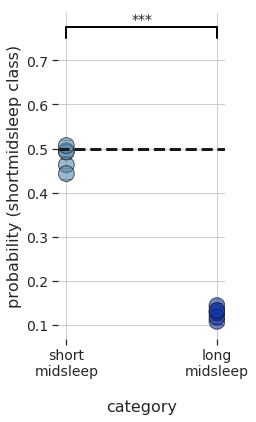

In [125]:
f, ax1 = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(3, 6))


ax1 = sns.scatterplot(data=mergedlightdeepsleepplot_df[mergedlightdeepsleepplot_df['depthcat']!= 'awake'],
                      x="time", y="classifier_prob", ax = ax1,
                      hue = 'depthcat',
                      **kwargs, s= 250, palette=depthcolor_dict, alpha = 0.6)


# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax1.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

errors = mergedlightdeepsleepplot_df[mergedlightdeepsleepplot_df['depthcat']!= 'awake']['sem']

(_, caps, _) = ax1.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', capsize=5,
                            zorder=-1, color = 'black', alpha = 0.5)


for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
sns.despine(left=True, bottom = True)

ax1.legend_.remove()

ax1.set_xticks(np.arange(1,3))
ax1.set_yticks(np.arange(0,0.8,0.1))


string_val1 = '***'
statannotation(ax = ax1, x1 = 1, x2 = 2, y = 0.75, text = string_val1)




labels = ['short\nmidsleep','long\nmidsleep']

ax1.set_xticklabels(labels)

ax1.axhline(0.5, ls='--', color = 'k', lw = 3)

# ax1.axvline(0, ls='--', color = 'k')

ax1.set_ylabel('probability (shortmidsleep class)', fontsize=label_fontsize)
ax1.set_xlabel('\ncategory', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)


plt.box(False)

# plt.savefig(outputfolderpath + 'classifier_midsleep_lightvsdeepsleep.png', format='png', dpi=300, 
#             transparent=False,bbox_inches='tight')